# COVID-19 Veri Analizi ve Makine Öğrenmesi Projesi

Bu proje Kaggle'daki [Coronavirus Dataset](https://www.kaggle.com/datasets/imdevskp/corona-virus-report) verisini kullanarak Exploratory Data Analysis (EDA), veri ön işleme ve sınıflandırma algoritmaları ile model geliştirme adımlarını içermektedir.

## Gerekli Kütüphanelerin Yüklenmesi

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np

warnings.filterwarnings('ignore')

## Verinin Yüklenmesi ve İlk İnceleme

In [3]:
df = pd.read_csv('/kaggle/input/corona-virus-report/covid_19_clean_complete.csv')
df.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region
0,NaN,Afghanistan,33.93911,67.709953,2020-01-22,0,0,0,0,Eastern Mediterranean
1,NaN,Albania,41.15330,20.168300,2020-01-22,0,0,0,0,Europe
2,NaN,Algeria,28.03390,1.659600,2020-01-22,0,0,0,0,Africa
3,NaN,Andorra,42.50630,1.521800,2020-01-22,0,0,0,0,Europe
4,NaN,Angola,-11.20270,17.873900,2020-01-22,0,0,0,0,Africa


In [4]:
# Veri hakkında genel bilgiler
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49068 entries, 0 to 49067
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Province/State  14664 non-null  object 
 1   Country/Region  49068 non-null  object 
 2   Lat             49068 non-null  float64
 3   Long            49068 non-null  float64
 4   Date            49068 non-null  object 
 5   Confirmed       49068 non-null  int64  
 6   Deaths          49068 non-null  int64  
 7   Recovered       49068 non-null  int64  
 8   Active          49068 non-null  int64  
 9   WHO Region      49068 non-null  object 
dtypes: float64(2), int64(4), object(4)
memory usage: 3.7+ MB


,Lat,Long,Confirmed,Deaths,Recovered,Active
count,49068.000000,49068.000000,4.906800e+04,49068.000000,4.906800e+04,4.906800e+04
mean,21.433730,23.528236,1.688490e+04,884.179160,7.915713e+03,8.085012e+03
std,24.950320,70.442740,1.273002e+05,6313.584411,5.480092e+04,7.625890e+04
min,-51.796300,-135.000000,0.000000e+00,0.000000,0.000000e+00,-1.400000e+01
25%,7.873054,-15.310100,4.000000e+00,0.000000,0.000000e+00,0.000000e+00
50%,23.634500,21.745300,1.680000e+02,2.000000,2.900000e+01,2.600000e+01
75%,41.204380,80.771797,1.518250e+03,30.000000,6.660000e+02,6.060000e+02
max,71.706900,178.065000,4.290259e+06,148011.000000,1.846641e+06,2.816444e+06


In [5]:
# Null değer kontrolü
df.isnull().sum()

Province/State    34404
Country/Region        0
Lat                   0
Long                  0
Date                  0
Confirmed             0
Deaths                0
Recovered             0
Active                0
WHO Region            0
dtype: int64

## Veri Ön İşleme

In [6]:
df = df.drop('Province/State', axis=1, errors='ignore')
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region
0,Afghanistan,33.93911,67.709953,2020-01-22,0,0,0,0,Eastern Mediterranean
1,Albania,41.15330,20.168300,2020-01-22,0,0,0,0,Europe
2,Algeria,28.03390,1.659600,2020-01-22,0,0,0,0,Africa
3,Andorra,42.50630,1.521800,2020-01-22,0,0,0,0,Europe
4,Angola,-11.20270,17.873900,2020-01-22,0,0,0,0,Africa


## Toplam vakaların tarihsel gelişimi

<Figure size 1200x600 with 0 Axes>

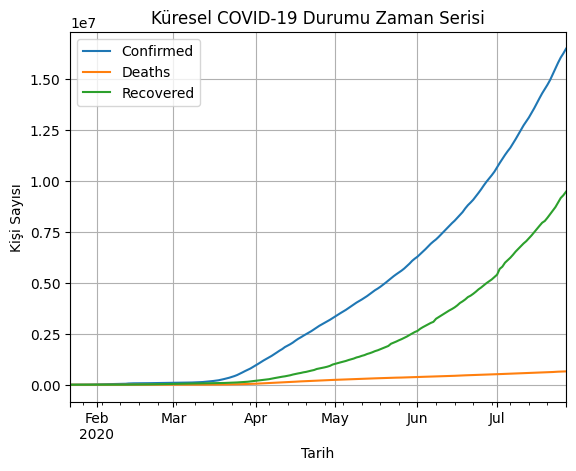

In [7]:
total_cases = df.groupby('Date')[['Confirmed', 'Deaths', 'Recovered']].sum()
plt.figure(figsize=(12,6))
total_cases.plot()
plt.title('Küresel COVID-19 Durumu Zaman Serisi')
plt.xlabel('Tarih')
plt.ylabel('Kişi Sayısı')
plt.grid(True)
plt.show()

## Özellik Mühendisliği, Etiketleme ve Veri Setinin Eğitim-Test Olarak Bölünmesi

In [9]:
latest_df = df[df['Date'] == df['Date'].max()]

features = latest_df[['Confirmed', 'Deaths', 'Recovered']]
latest_df['Severe'] = (latest_df['Deaths'] / latest_df['Confirmed']) > 0.05
labels = latest_df['Severe'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

## Farklı Makine Öğrenmesi Modelleri ile Karşılaştırma

In [10]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC()
}

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"{name} - Accuracy: {scores.mean():.4f} (+/- {scores.std():.4f})")


Logistic Regression - Accuracy: 0.9856 (+/- 0.0118)
Decision Tree - Accuracy: 0.8411 (+/- 0.0303)
KNN - Accuracy: 0.8079 (+/- 0.0289)
SVM - Accuracy: 0.8317 (+/- 0.0020)


## GridSearchCV ile Lojistik Regresyon Optimizasyonu

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
print("Best Cross-Validation Score:", grid.best_score_)


Best Parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Best Cross-Validation Score: 0.9952380952380953


## Nihai Modelin Eğitimi ve Değerlendirilmesi

In [20]:
# Final model
final_model = LogisticRegression(C=0.01, penalty='l2', solver='liblinear', max_iter=1000)
final_model.fit(X_train, y_train)

LogisticRegression(C=0.01, max_iter=1000, solver='liblinear')

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

y_pred = final_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

print("🔎 Accuracy:", accuracy)
print("🔎 Precision:", precision)
print("🔎 Recall:", recall)
print("🔎 F1 Score:", f1)
print("\n📊 Confusion Matrix:\n", conf_matrix)
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred))


🔎 Accuracy: 0.9811320754716981
🔎 Precision: 0.9815335206744279
🔎 Recall: 0.9811320754716981
🔎 F1 Score: 0.9805078265212167

📊 Confusion Matrix:
 [[46  0]
 [ 1  6]]

📋 Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        46
           1       1.00      0.86      0.92         7

    accuracy                           0.98        53
   macro avg       0.99      0.93      0.96        53
weighted avg       0.98      0.98      0.98        53



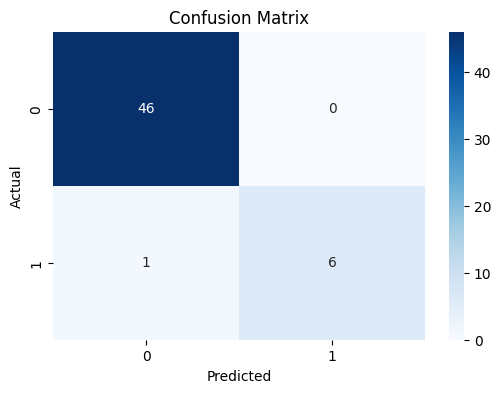

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
